In [3]:
"""
script to load filter particles (reached square at z_reach) 
and interpolate variable on it
beta testing before script 
"""
# ----------------------------------------------------------------------------
import numpy as np
import numpy.ma as ma
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import time
import os
import sys
# from numba import jit
import ctypes
import multiprocessing as mp
import warnings

# pyticles related modules and tools
sys.path.append("../../Modules/")
import pyticles_sig_sa as part
import R_vars as va
from R_files import load
import xarray as xr


In [4]:
def var_shape(grid_type, coord=None, simul=None):
    """
    return variable shape according to it's roms-grid
    
    parameters : str, grid (grid type)
                - rho: for tracers (t, s, rho)
                - rho-w: for w
                - psi: for vorticity 
                - psi-w ?
                - u zonal velocity
                - v meridional velocity      
    """
    if coord is None:
        coord = simul.coord[0:4]
        
    [j0, j1, i0, i1]=coord
    
    # --> horizontal shape
    if 'rho' in grid_type:
        nx = i1 - i0
        ny = j1 - j0
    elif 'psi' in grid_type:
        nx = i1 - i0 - 1
        ny = j1 - j0 - 1
    elif 'u' in grid_type:
        nx = i1 - i0 - 1
        ny = j1 - j0
    elif 'v' in grid_type:
        nx = i1 - i0
        ny = j1 - j0 - 1
    
    # vertical shape
    if 'w' in grid_type:
        nz = np.max(simul.coord[4]) + 1
    else:
        nz = np.max(simul.coord[4])
        
    return nx, ny, nz

In [5]:
def tight_coord(px, py):
    "tight coordinates for interpolation"
    coord = np.array([np.floor(np.nanmin(py)), np.ceil(np.nanmax(py)),
                np.floor(np.nanmin(px)), np.ceil(np.nanmax(px))], dtype=int)
    return None

In [6]:
from dask.distributed import Client, progress

client = Client()
client

/home2/datahome/jcollin/conda-env/pyticles_pp/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 56566 instead
  http_address["port"], self.http_server.port


Client Scheduler: tcp://127.0.0.1:37359 Dashboard: http://127.0.0.1:56566/status,Cluster Workers: 8 Cores: 56 Memory: 123.48 GB


In [8]:
%%time
if __name__=='__main__':
    
    small = True
    
    if small:
        part_path = '/home/datawork-lemar-apero/jcollin/pyticles/cfl/'
        partfile = part_path + 'uncompressed_substep-cfl0.1-bis_28_3800.nc'
    else:
        part_path = '/home2/datawork/jcollin/Pyticles/xarray/'
        partfile = part_path + 'traj_winter06.nc'
    
    with Dataset(partfile, 'r') as nc:
        ptime = nc.variables['time'][:]
    
    varname = 'rho1'
    my_simul = 'polgyr'
    
    parameters = my_simul + ' [0,10000,0,10000,[1,100,1]] '+ format(np.int(ptime[0]))
    simul = load(simul = parameters, floattype=np.float64)
    nx, ny, nz = [simul.coord[1], simul.coord[3], simul.coord[4].size]
    
    # --> I/O
    if small:
        chunk_nq = 10
        chunk_time = -1
    else:
        chunk_nq = 1e5
        chunk_time = -1

    # --> open pyticles file with chunks to spare memory
    ds = xr.open_dataset(    
        partfile,
        chunks={
            "nq": chunk_nq,
            "time": chunk_time,
        },
    )
    
    # --> ouputs
    result_file = part_path + 'traj_seq_' + varname + 'xarray' + '.nc'
        
    # --> time loop
    for tt in np.arange(ptime.size):
        print('time step = {}'.format(ptime[tt]))
        simul.update(np.round(ptime[tt])) 
        
        # --> get smallest domain with particles (fast loading)
        t0 = time.time()
        px = ds.px.isel(time=tt).persist()
        py = ds.py.isel(time=tt).persist()
        pz = ds.pz.isel(time=tt).persist()
        
        coord = tight_coord(px, py).compute()
        print(f"--> time to load particles position {time.time() - t0} s")
        
        t0 = time.time()
        var =  xr.DataArray(
                va.var(varname, simul, method = 'new', coord=coord).data,
                dims=("nx", "ny", "nz"),
                name=varname,
        )#.chunk(chunks=)
        print(f"--> time to load {varname} {time.time() - t0} s")
        
        t0 = time.time()
        pvar = part.map_var(simul, var, px, py, pz, ng=1, coord=coord)
            
        print(f"--> time to interpolate {varname} {time.time() - t0} s")
        
    t0 = time.time()
    dsout = xr.Dataset(
        data_vars=dict(
            pu=(["time", "nq"], pu),
        ),
        coords=ds.coords
    )
    
    dsout.load().to_netcdf(result_file, encoding={'nq': {'dtype': 'i4'}})
    print(f"--> time to write {varname} in netcdf file {time.time() - t0} s")

simulname is None
args (['polgyr', '[0,10000,0,10000,[1,100,1]]', '3800'],)
args[0] ['polgyr', '[0,10000,0,10000,[1,100,1]]', '3800']
len(args[0]) 3
time of simulation is: 3800
coord
loading /home/datawork-lops-osi/mlecorre/POLGYR/INIT/polgyr_grd.nc
loading /home/datawork-lops-osi/mlecorre/POLGYR/HIS/polgyr_his.03800.nc
get domain [0,10000,0,10000,[1,100,1]] [0,10
coordmax
loading /home/datawork-lops-osi/mlecorre/POLGYR/INIT/polgyr_grd.nc
loading /home/datawork-lops-osi/mlecorre/POLGYR/HIS/polgyr_his.03800.nc
get domain [0,1e9,0,1e9,[1,1e9,1]] [0,1e
cst
read Cs_r in ncfile.Cs_r
dt
dt is read in  /home/datawork-lops-osi/mlecorre/POLGYR/HIS/polgyr_his.03800.nc
[0, 1602, 0, 2002, array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70,

AttributeError: 'NoneType' object has no attribute 'compute'

## gain de temps x3 en gros
    CPU times: user 22min 6s, sys: 15.3 s, total: 22min 21s
    Wall time: 6min 58s

last time step :

    --> time to load rho1 0.9064481258392334 s
    --> time to interpolate rho1 0.006160259246826172 s
    --> time to write rho1 in netcdf file 0.05327153205871582 s

In [2]:
import xarray as xr
from dask.distributed import Client, progress

client = Client()
client


Client Scheduler: tcp://127.0.0.1:37571 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 56 Memory: 123.48 GB


In [ ]:
small = False
    
if small:
    part_path = '/home/datawork-lemar-apero/jcollin/pyticles/cfl/'
    partfile = part_path + 'uncompressed_substep-cfl0.1-bis_28_3800.nc'
else:
    part_path = '/home2/datawork/jcollin/Pyticles/xarray/'
    partfile = part_path + 'traj_winter06.nc'

nprocs = 1
varname = 'rho1'
# --> ouputs
result_file = part_path + 'traj_seq_' + varname + str(nprocs) + '.nc'

chunk_nq = 1e5
ds = xr.open_dataset(
    result_file,
    chunks={
        "nq": chunk_nq,
        "time": -1,
    },
)



In [13]:
ds.info()

xarray.Dataset {
dimensions:
	nq = 1110162 ;
	time = 180 ;

variables:
	float64 rho1(time, nq) ;

// global attributes:
}

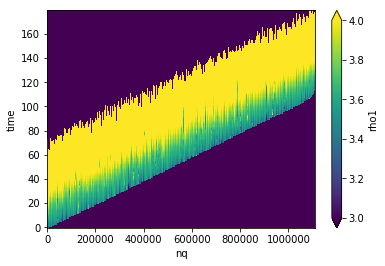

In [12]:
ds.rho1.plot(vmin=3, vmax=4)